In [1]:
import sys
import os
import numpy as np

from tokenizer.EncoderDecoder import encoder, decoder
from tokenizer.utils import load_bpe, render_token

from io import BufferedReader
import matplotlib.pyplot as plt
import functools
import multiprocessing
from tqdm import tqdm, trange
import math

import torch
import torch.nn.functional as F

In [2]:
NPROC = 16
VOCAB_SIZE = 1256
D = 512 # model dimension (embeddings)
S = 100 # Sequence lenght (context)

# Tokenization

In [3]:
def get_chunk_boundaries(file_path: str, special_token: str = '<|endoftext|>'):
    f: BufferedReader = open(file_path, 'rb')
    content = f.read()
    f.close()    

    chunk_starts = [0]
    start_index = 0
    while True:
        match_index = content.find(special_token.encode('utf-8'), start_index)
        if match_index == -1:
            break
        chunk_starts.append(match_index + len(special_token))
        start_index = match_index + len(special_token)
    chunk_ends = chunk_starts[1:]
    chunk_ends.append(len(content))
    chunk_boundaries = list(zip(chunk_starts, chunk_ends))

    return chunk_boundaries

In [4]:
def encode_chunk(chunk_boundaries: tuple, file_path: str, model: str):
    f = open(file_path, 'rb')
    chunk_start, chunk_end = chunk_boundaries
    
    f.seek(chunk_start)

    tokens = encoder(f.read(chunk_end-chunk_start).decode(), model=model)
    f.close()
    return tokens, len(tokens)

In [5]:
def tokenize_train_data(file_path: str, tokenizer:str):
    encode_f = functools.partial(encode_chunk, file_path=file_path, model=tokenizer)

    chunks_boundaries = get_chunk_boundaries(file_path=file_path)

    chunks_tokens = []
    with multiprocessing.Pool(NPROC) as p:
        for chunk in tqdm(p.imap_unordered(encode_f, chunks_boundaries), total=len(chunks_boundaries), desc="Tokenizing"):
            chunks_tokens.append(chunk)
        p.close()
        p.join()
    
    return chunks_tokens

In [6]:
tokens = tokenize_train_data('tokenizer/data/toy_data.txt', tokenizer='tinystories')

Tokenizing: 100%|██████████| 460/460 [00:04<00:00, 95.67it/s] 


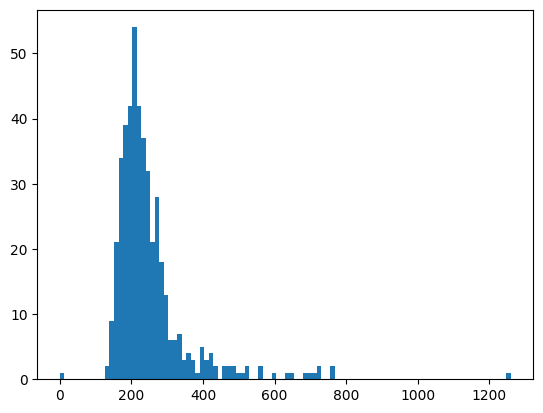

In [7]:
lenghts = [ lenght for _, lenght in tokens ]
plt.hist(lenghts, bins=100);

In [8]:
def dataloader(chunks: list, B: int, S: int, stride: int):
    inputs = []
    targets = []
    for tokens, lenght in chunks:
        for idx in range(0, lenght - S - 1, stride):
            inputs.append(tokens[idx:idx + S])
            targets.append(tokens[idx+1:idx + S + 1])

    for i in range(0, len(inputs), B):
        batch_inputs = inputs[i:i + B]
        batch_targets = targets[i:i + B]
        
        if len(batch_inputs) == B:
            yield batch_inputs, batch_targets

    return batch_inputs, batch_targets

# Embeddings 

In [3]:
np.random.seed(123)

In [4]:
S = 3           # Sequence lenght
D = 8           # Model dimension (embedding size)
N_HEADS = 2
D_K = D // N_HEADS         # Dimension of keys (used to scale attention)
B = 2
NBATCHES = 1
VOCAB_SIZE = 10

W_TE = np.random.rand(VOCAB_SIZE, D) # VOCAB_SIZE x D
W_PE = np.random.rand(S, D)

W_Q = np.random.rand(D, D_K * N_HEADS)
W_K = np.random.rand(D, D_K * N_HEADS)
W_V = np.random.rand(D, D_K * N_HEADS)
W_O = np.random.rand(D, D)

GAMMA = np.random.rand(B, S, 1)
BETA = np.random.rand(B, S, 1)

FFN_EXPCON_FAC = 4
W_FFN_E = np.random.rand(D, FFN_EXPCON_FAC * D)
W_FFN_C = np.random.rand(FFN_EXPCON_FAC * D, D)

W_LOGITS = np.random.rand(B, D, VOCAB_SIZE)

# GAMMA = np.ones((B,S,1))
# BETA = np.zeros((B,S,1))

# W_O = 
# W_FF_expand = 
# W_FF_contract =
# gamma =
# beta =

In [5]:
from transformer import (
    softmax,
    relu,
    qkv_projection,
    layer_norm,
    feed_forward_network,
    block_forward,
    multi_head_attention_backward,
    softmax_backward_from_probs   
)

from transformer import multi_head_attention as mha_np
from transformer import multi_head_attention_backward as mha_back_np

from torch_primitives import torch_multi_head_attention_backward as mha_back_torch

In [6]:
def multi_head_attention(q: np.ndarray, k: np.ndarray, v: np.ndarray) -> np.ndarray:
    assert q.shape == k.shape

    # NOTE: swapaxes(1,2) is a final step after reshape to split the q matrix into each head
    #       the final swapaxes(2,3) in tensor k is for transpose in the attention score calculation
    attn_scores = q.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) @ k.reshape(B,S,N_HEADS,D_K).swapaxes(1,2).swapaxes(2,3)
    mask = np.tril(np.ones(attn_scores.shape), k=0).astype(bool)
    attn_scores_masked = np.where(mask, attn_scores, -np.inf)

    scale = 1.0 / np.sqrt(q.shape[-1])
    causal_attn = softmax(attn_scores_masked * scale)

    context_vectors = causal_attn @ v.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) # Applies same reshape and swap as q & k

    return context_vectors.swapaxes(1,2).reshape(B,S,D_K * N_HEADS) # Concat context vector from each head

In [7]:
def block_forward(x: np.ndarray):
    q, k, v = qkv_projection(x, W_Q, W_K, W_V)
    print(f"qkv_proj: {(x.shape, q.shape, k.shape, v.shape)}")

    context_vec = multi_head_attention(q, k, v)
    attn_out = context_vec @ W_O
    print(f"causal attn: {attn_out.shape}")

    ln_attn = layer_norm(x + attn_out, GAMMA, BETA)
    print(f"layer norm (attn): {ln_attn.shape}")

    ffn = feed_forward_network(ln_attn, W_FFN_E, W_FFN_C)
    print(f"ffn: {ffn.shape}")

    ln_head = layer_norm(ln_attn + ffn, GAMMA, BETA)
    print(f"layer norm head: {ln_head.shape}")

    return ln_head


In [8]:
data = np.random.randint(1, VOCAB_SIZE, (NBATCHES,B,S))

input_emb = W_TE[data] + W_PE[np.arange(S)] # S x D
print(f"data: {data.shape}")
print(f"input emb: {input_emb.shape}")

for batch in input_emb:
    l1 = block_forward(batch)
    l2 = block_forward(l1)
    l3 = block_forward(l2)
    logits = softmax(l3 @ W_LOGITS)
    tokens = np.argmax(logits[:-1], axis=-1)
tokens

data: (1, 2, 3)
input emb: (1, 2, 3, 8)
qkv_proj: ((2, 3, 8), (2, 3, 8), (2, 3, 8), (2, 3, 8))
causal attn: (2, 3, 8)
layer norm (attn): (2, 3, 8)
ffn: (2, 3, 8)
layer norm head: (2, 3, 8)
qkv_proj: ((2, 3, 8), (2, 3, 8), (2, 3, 8), (2, 3, 8))
causal attn: (2, 3, 8)
layer norm (attn): (2, 3, 8)
ffn: (2, 3, 8)
layer norm head: (2, 3, 8)
qkv_proj: ((2, 3, 8), (2, 3, 8), (2, 3, 8), (2, 3, 8))
causal attn: (2, 3, 8)
layer norm (attn): (2, 3, 8)
ffn: (2, 3, 8)
layer norm head: (2, 3, 8)


array([[3, 3, 0]])

In [9]:
np.random.seed(123)
q = np.random.rand(2,1,3,4)
k = np.random.rand(2,1,3,4)
v = np.random.rand(2,1,3,4)

dOut = np.random.rand(2,1,3,4)

In [12]:
mha_np(q, k, v, unmasked=False)#.sum(axis=-1, keepdims=True)

array([[[[0.51948512, 0.61289453, 0.12062867, 0.8263408 ],
         [0.55812428, 0.58153635, 0.22332821, 0.5849033 ],
         [0.51260863, 0.61351953, 0.4474817 , 0.54803669]]],


       [[[0.66931378, 0.58593655, 0.6249035 , 0.67468905],
         [0.74549826, 0.36457956, 0.68600801, 0.48490987],
         [0.54490799, 0.45948477, 0.47326716, 0.64405419]]]])

In [44]:
mha_np(q, k, v)#.sum(axis=-1, keepdims=True)

ValueError: cannot reshape array of size 24 into shape (1,4,2,8)

In [45]:
import torch
import torch.nn.functional as F

In [46]:
def mha_torch(q, k, v):
    q_torch = torch.from_numpy(q).float().requires_grad_(True)
    k_torch = torch.from_numpy(k).float().requires_grad_(True)
    v_torch = torch.from_numpy(v).float().requires_grad_(True)

    # Multi-head attention forward pass
    d_h = q_torch.shape[-1]
    mask = torch.triu(torch.ones(2,3,3), diagonal=1)
    attn_scores = q_torch @ k_torch.transpose(-2, -1) / np.sqrt(d_h)
    causal_attn_scores = attn_scores.masked_fill(mask.bool(), -torch.inf)
    attn_weights = F.softmax(causal_attn_scores, dim=-1)
    output_torch = attn_weights @ v_torch

    return output_torch

# output_torch.backward(dOut_torch)

In [47]:
mha_torch(q, k, v)

tensor([[[[0.5195, 0.6129, 0.1206, 0.8263],
          [0.5581, 0.5815, 0.2233, 0.5849],
          [0.5126, 0.6135, 0.4475, 0.5480]],

         [[0.5195, 0.6129, 0.1206, 0.8263],
          [0.5581, 0.5815, 0.2233, 0.5849],
          [0.5126, 0.6135, 0.4475, 0.5480]]],


        [[[0.6693, 0.5859, 0.6249, 0.6747],
          [0.7455, 0.3646, 0.6860, 0.4849],
          [0.5449, 0.4595, 0.4733, 0.6441]],

         [[0.6693, 0.5859, 0.6249, 0.6747],
          [0.7455, 0.3646, 0.6860, 0.4849],
          [0.5449, 0.4595, 0.4733, 0.6441]]]], grad_fn=<UnsafeViewBackward0>)

In [48]:
def multi_head_attention_backward(q: np.ndarray, k: np.ndarray, v: np.ndarray, dOut: np.ndarray):
    B, N_HEADS, S, D_K = q.shape
    scale = 1.0 / np.sqrt(D_K)

    attn_scores = q.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) @ k.reshape(B,S,N_HEADS,D_K).swapaxes(1,2).swapaxes(2,3)
    mask = np.tril(np.ones((B,N_HEADS,S,S)), k=0).astype(bool)
    attn_scores_masked = np.where(mask, attn_scores, -np.inf)

    scale = 1.0 / np.sqrt(q.shape[-1])
    causal_attn = softmax(attn_scores_masked * scale)

    dV = np.swapaxes(causal_attn, -2, -1) @ dOut.reshape(B,S,N_HEADS,D_K).swapaxes(1,2)
    dAttn = dOut.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) @ np.swapaxes(v.reshape(B,S,N_HEADS,D_K).swapaxes(1,2), -2, -1)

    dScores = softmax_backward_from_probs(causal_attn, dAttn)

    dQ = dScores @ k.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) * scale
    dK = np.swapaxes(dScores, -2, -1) @ q.reshape(B,S,N_HEADS,D_K).swapaxes(1,2) * scale
    return dQ, dK, dV

In [49]:
def torch_multi_head_attention_backward(q_np, k_np, v_np, dOut_np):
    """PyTorch implementation of multi-head attention backward pass"""
    q_torch = torch.from_numpy(q_np).float().requires_grad_(True)
    k_torch = torch.from_numpy(k_np).float().requires_grad_(True)
    v_torch = torch.from_numpy(v_np).float().requires_grad_(True)
    dOut_torch = torch.from_numpy(dOut_np).float()

    B, N_HEADS, S, D_K = q_torch.shape
    print(q_torch.shape)

    # Multi-head attention forward pass
    mask = torch.triu(torch.ones(B, N_HEADS, S, S), diagonal=1)
    attn_scores = q_torch @ k_torch.transpose(-2, -1) / np.sqrt(D_K)
    causal_attn_scores = attn_scores.masked_fill(mask.bool(), -torch.inf)
    attn_weights = F.softmax(causal_attn_scores, dim=-1)
    output_torch = attn_weights @ v_torch
    print(output_torch.shape)

    output_torch.backward(dOut_torch)

    return (
        q_torch.grad.detach().numpy(),
        k_torch.grad.detach().numpy(),
        v_torch.grad.detach().numpy(),
    )

In [50]:
multi_head_attention_backward(q, k, v, dOut)[0]

array([[[[ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.01563788, -0.01123491,  0.0098367 , -0.00749334],
         [ 0.00040571, -0.00184811,  0.01019378, -0.00243235]]],


       [[[ 0.        ,  0.        ,  0.        ,  0.        ],
         [-0.01165394,  0.04587054,  0.03697114,  0.00513161],
         [-0.0142082 ,  0.03768114,  0.02941429, -0.00509489]]]])

In [51]:
torch_multi_head_attention_backward(q, k, v, dOut)[0]

torch.Size([2, 1, 3, 4])
torch.Size([2, 1, 3, 4])


array([[[[ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.01563788, -0.01123491,  0.0098367 , -0.00749334],
         [ 0.0004057 , -0.00184811,  0.01019377, -0.00243235]]],


       [[[ 0.        ,  0.        ,  0.        ,  0.        ],
         [-0.01165394,  0.04587054,  0.03697114,  0.00513161],
         [-0.0142082 ,  0.03768113,  0.02941428, -0.0050949 ]]]],
      dtype=float32)

In [18]:
mha_back_np(q, k, v, dOut)[0]

ValueError: cannot reshape array of size 24 into shape (1,3,1,4)

In [101]:
mha_back_torch(q,k,v,dOut)[0]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.01563788, -0.01123491,  0.0098367 , -0.00749334],
        [ 0.0004057 , -0.00184811,  0.01019377, -0.00243235]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.01165394,  0.04587054,  0.03697114,  0.00513161],
        [-0.0142082 ,  0.03768113,  0.02941428, -0.0050949 ]]],
      dtype=float32)

In [64]:
mask.bool().shape

torch.Size([2, 3, 3])

In [57]:
attn_scores.shape

torch.Size([2, 3, 3])

In [14]:
k.swapaxes(1,2).shape

(2, 4, 3)

In [47]:
mha_back_torch(q, k, v, dOut)[0]

array([[[ 0.01127838, -0.00791101,  0.00586967, -0.00512856],
        [ 0.01035594, -0.00737556,  0.00610205, -0.00486952],
        [ 0.0004057 , -0.00184811,  0.01019377, -0.00243235]],

       [[-0.02505569,  0.03117587,  0.02159204, -0.03093255],
        [-0.01166164,  0.03306082,  0.0259736 , -0.00285432],
        [-0.0142082 ,  0.03768113,  0.02941428, -0.0050949 ]]],
      dtype=float32)

In [650]:
a = np.array([[1,7,3],[4,5,6]])
a

array([[1, 7, 3],
       [4, 5, 6]])

In [652]:
np.argmax(a, axis=0)

array([1, 0, 1])

In [658]:
a = np.array([[[1,2],[3,4]],[[5,6],[7,8]]])

In [659]:
a @ a

array([[[  7,  10],
        [ 15,  22]],

       [[ 67,  78],
        [ 91, 106]]])

In [662]:
a[1] @ a[1]

array([[ 67,  78],
       [ 91, 106]])